# preprocess data
split the eeg into small chunks

In [21]:
from tqdm.notebook import tqdm
from scipy.signal import butter, lfilter, sosfilt
import pandas as pd
import numpy as np
import torch as t

import matplotlib.pyplot as plt

In [6]:
OUT_DIR = './eeg-robust-filter/'
BASE_PATH = './hms-harmful-brain-activity-classification/'
DATA_PATH = './hms-harmful-brain-activity-classification/train_eegs/'

In [23]:
# data has shape (sequence_len=10000, probes=20)

def clip(data, bound=300):
    return np.clip(data, -bound, bound)

def robust_norm(data):
    median = np.median(data, axis=0)
    q75, q25 = np.percentile(data, [75 ,25], axis=0)
    iqr = q75 - q25
    iqr[iqr < 1e-6] = 1e-6 # numerical stability
    return (data - median) / iqr

def band_filter(data, low=1, high=70, fs=200, order=4):
    sos = butter(N=order, Wn=[low, high], btype='bandpass', fs=fs, output='sos')
    return sosfilt(sos, data, axis=0)

# def logify(data):
#     log_data = np.log1p(np.abs(data))
#     log_data[data < 0] *= -1
#     return log_data

# def normalize_signals(data):
#     mean = data.mean(axis=0, keepdims=True)
#     std = data.std(axis=0, keepdims=True)
#     std_adjusted = np.where(std > 1e-10, std, 1) # numerical stability
#     return (data - mean) / std_adjusted

# def butter_bandpass_filter(data, lowcut=1. , highcut =40., fs=200, order=6):
#     b, a = butter(order, [lowcut / (0.5 * fs), highcut / (0.5 * fs)], btype='band')
#     return lfilter(b, a, data)

def filters(data):
    data = band_filter(data)
    data = robust_norm(data)
    return data

  0%|          | 0/17089 [00:00<?, ?it/s]

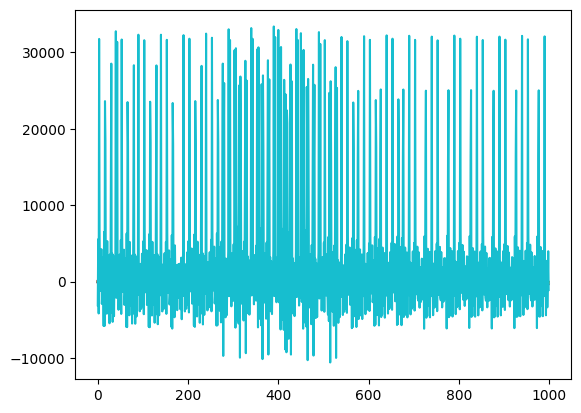

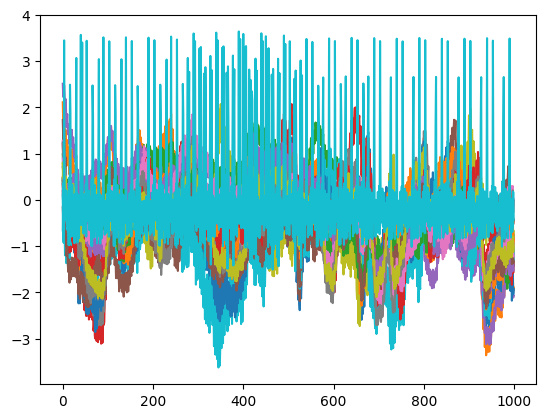

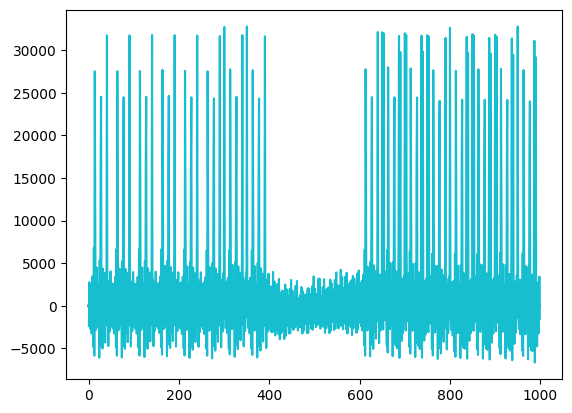

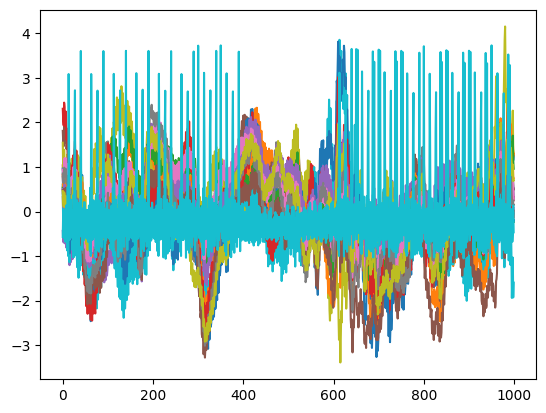

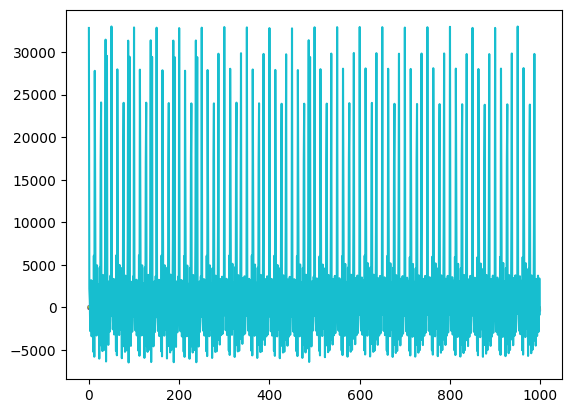

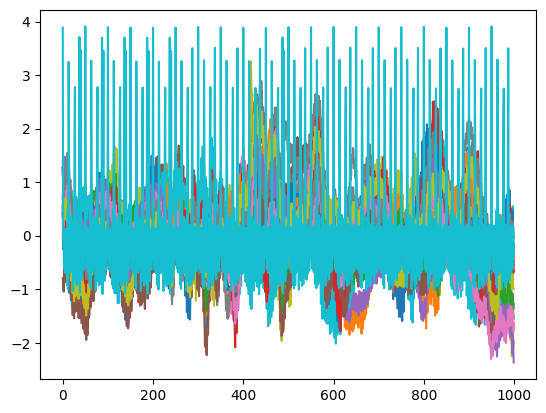

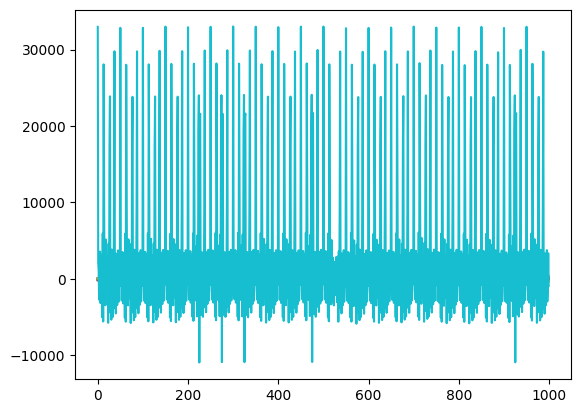

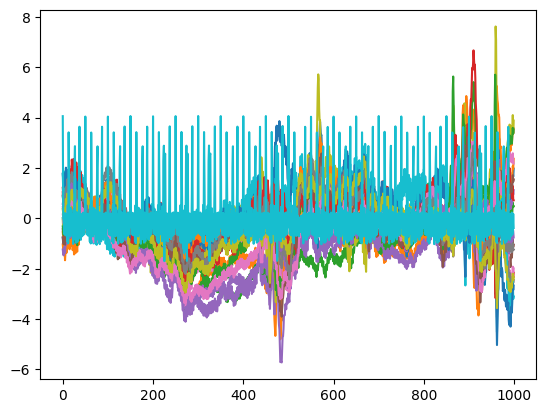

In [26]:
def preprocess(df):
    sample_rate = 200
    duration = 10_000
    for eeg_id, group in tqdm(df.groupby('eeg_id')):
        parquet_file = f'{DATA_PATH}{eeg_id}.parquet'
        raw_eeg = pd.read_parquet(parquet_file)
        for _, row in group.iterrows():
            eeg_sub_id = row['eeg_sub_id']
            offset = int(row['eeg_label_offset_seconds'] * sample_rate)
            eeg = raw_eeg.iloc[offset:offset + duration]
            eeg = eeg.ffill(axis=0).fillna(0)
            filtered_eeg = filters(eeg.values)
            data = t.tensor(filtered_eeg).float()
            # plt.plot(eeg.values[:1000])
            # plt.show()
            # plt.plot(filtered_eeg[:1000])
            # plt.show()
            t.save(data, f'{OUT_DIR}{eeg_id}_{eeg_sub_id}.pt')

df = pd.read_csv(f'{BASE_PATH}train.csv')
preprocess(df)